In [1]:
!git clone https://github.com/vkhoi/KTH-Action-Recognition.git

Cloning into 'KTH-Action-Recognition'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 709.16 KiB | 32.23 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [2]:
%cd /content/KTH-Action-Recognition/dataset

/content/KTH-Action-Recognition/dataset


In [ ]:
#OPENCV VERSION FOR USING SIFT
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0MB 115kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 74kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
#OPENCV VERSION FOR ORB AND BEBLID
!pip install "opencv-contrib-python>=4.5.1"

     |████████████████████████████████| 66.5 MB 7.0 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [4]:
#for installing rar file
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 77 kB 5.6 MB/s 


In [5]:
from pyunpack import Archive
Archive('Biking.rar').extractall('/content/KTH-Action-Recognition/dataset')
Archive('JumpingJack.rar').extractall('/content/KTH-Action-Recognition/dataset')
Archive('Kayaking.rar').extractall('/content/KTH-Action-Recognition/dataset')
Archive('PlayingGuitar.rar').extractall('/content/KTH-Action-Recognition/dataset')
Archive('Rowing.rar').extractall('/content/KTH-Action-Recognition/dataset')
Archive('Skijet.rar').extractall('/content/KTH-Action-Recognition/dataset')
Archive('TaiChi.rar').extractall('/content/KTH-Action-Recognition/dataset')

!rm *.rar

In [6]:
#CODE FOR EXTRACTING Spatio temporal SIFT/BEBLID VALUES as features and storing as feature files all categories in one pickle file

import cv2
import numpy as np
import os
import pickle
import cv2
import numpy as np

import math
from sklearn.cluster import KMeans
from sklearn import preprocessing

def extract_denseSIFT(img):
    DSIFT_STEP_SIZE = 2
    #sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.xfeatures2d.BEBLID_create(1)
    disft_step_size = DSIFT_STEP_SIZE
    keypoints = [cv2.KeyPoint(x, y, disft_step_size)
            for y in range(0, img.shape[0], disft_step_size)
                for x in range(0, img.shape[1], disft_step_size)]

    descriptors = sift.compute(img, keypoints)[1]
    
    #keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors


#CATEGORIES = ["boxing", "handclapping", "handwaving", "jogging", "running", "walking"]
CATEGORIES = ["Biking", "JumpingJack", "Kayaking", "PlayingGuitar", "Rowing", "Skijet", "TaiChi"]

if __name__ == "__main__":

    # Create directory to store extracted pixel features.
    os.makedirs("data", exist_ok=True)

    
    n_processed_files = 0
    features = []
    L = 1

    for category in CATEGORIES:
        print("Processing category %s" % category)

        # Get all files in current category's folder.
        folder_path = os.path.join("..", "dataset", category)
        filenames = os.listdir(folder_path)

        # List to store features. features[i] stores features for the i-th video
        # in current category.
        #features = []

        for filename in filenames:
            filepath = os.path.join("..", "dataset", category, filename)
            path = "/content/KTH-Action-Recognition/dataset/" + category + "/" + filename
            vid = cv2.VideoCapture(filepath)

            features_current_file_new = []
            count_frame = 0
            while vid.isOpened():
              ret, frame = vid.read()
              count_frame = count_frame + 1
              if not ret:
                break
              if(count_frame < (2**L + 1)):
  # Only care about gray scale.
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                W = frame.shape[1]
                H = frame.shape[0]   
                h = []
                for l in range(L+1):
                  w_step = math.floor(W/(2**l))
                  h_step = math.floor(H/(2**l))
                  x, y = 0, 0
                  for i in range(1,2**l + 1):
                    x = 0
                    for j in range(1, 2**l + 1):                
                      desc = extract_denseSIFT(frame[y:y+h_step, x:x+w_step])                
                #print("type:",desc is None, "x:",x,"y:",y, "desc_size:",desc is None)
                      kmeans = KMeans(n_clusters=60, init='k-means++', max_iter=300, n_init=10, random_state=0)
                      predict = kmeans.fit_predict(desc)
                      histo = np.bincount(predict, minlength=60).reshape(1,-1).ravel()
                      weight = 2**(l-L)
                      h.append(weight*histo)
                      x = x + w_step
                    y = y + h_step
            
                hist = np.array(h).ravel()
    # normalize hist
                dev = np.std(hist)
                hist -= np.mean(hist)
                hist /= dev

                features_current_file_new.append(hist)
    
                features_current_file = np.array(features_current_file_new)


            # Store features in current file.
    

# No of frames
#print((features_current_file))  
 #     features_current_file = np.array(features_current_file_new)

            print(filename)    
            print(path)
            features.append({
                "filename": filename,
                "path" : path,
                "category": category,
                "features": features_current_file 
            })

            n_processed_files += 1
            if n_processed_files % 30 == 0:
                print("Done %d files" % n_processed_files)

        # Dump data to file.
pickle.dump(features, open("data/keyframesTransnet_Cluster_BEBLID_stpm_UCF50_L1.p" , "wb"))


Processing category Biking
Biking3.mp4
/content/KTH-Action-Recognition/dataset/Biking/Biking3.mp4
Biking2.mp4
/content/KTH-Action-Recognition/dataset/Biking/Biking2.mp4
Biking4.mp4
/content/KTH-Action-Recognition/dataset/Biking/Biking4.mp4
Biking1.mp4
/content/KTH-Action-Recognition/dataset/Biking/Biking1.mp4
Processing category JumpingJack
JumpingJack2.mp4
/content/KTH-Action-Recognition/dataset/JumpingJack/JumpingJack2.mp4
JumpingJack1.mp4
/content/KTH-Action-Recognition/dataset/JumpingJack/JumpingJack1.mp4
JumpingJack3.mp4
/content/KTH-Action-Recognition/dataset/JumpingJack/JumpingJack3.mp4
JumpingJack4.mp4
/content/KTH-Action-Recognition/dataset/JumpingJack/JumpingJack4.mp4
Processing category Kayaking
Kayaking1.mp4
/content/KTH-Action-Recognition/dataset/Kayaking/Kayaking1.mp4
Kayaking2.mp4
/content/KTH-Action-Recognition/dataset/Kayaking/Kayaking2.mp4
Kayaking3.mp4
/content/KTH-Action-Recognition/dataset/Kayaking/Kayaking3.mp4
Kayaking4.mp4
/content/KTH-Action-Recognition/dataset

In [12]:
#CBVR SAMPLE TEST BENCH FOR STPM_SIFT_HISTOGRAM_INTERSECTION / STPM_BEBLID_HISTOGRAM_INTERSECTION BASED COMPARISONS
#Accessing the feature database

#OPENCV VERSION FOR ORB AND BEBLID
#!pip install "opencv-contrib-python>=4.5.1"

import pickle
import cv2
import numpy as np
import pandas as pd
from pandas import DataFrame
import math
from sklearn.cluster import KMeans
from sklearn import preprocessing

#40800
def histogram_intersection(h1, h2, l):
    sm = 0

    for i in range(l):
        sm += min(h1[i], h2[i])
    return sm


# List to store result
feature_result = []

#CODE TO EXTRACT FEATURES FROM QUERY IMAGE


#QUERY VIDEO
import cv2
import numpy as np

import math

def extract_denseSIFT(img):
    DSIFT_STEP_SIZE = 2
    #sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.xfeatures2d.BEBLID_create(1)
    disft_step_size = DSIFT_STEP_SIZE
    keypoints = [cv2.KeyPoint(x, y, disft_step_size)
            for y in range(0, img.shape[0], disft_step_size)
                for x in range(0, img.shape[1], disft_step_size)]

    descriptors = sift.compute(img, keypoints)[1]
    
    #keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

L = 1
#QUERY VIDEO
filepath = '/content/KTH-Action-Recognition/dataset/TaiChi/TaiChi2.mp4'
vid = cv2.VideoCapture(filepath)

            # Store features in current file.
features_current_file_new = []
count_frame = 0
while vid.isOpened():
  ret, frame = vid.read()
  count_frame = count_frame + 1
  if not ret:
    break
  if(count_frame < (2**L + 1)):
  # Only care about gray scale.
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    W = frame.shape[1]
    H = frame.shape[0]   
    h = []
    for l in range(L+1):
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):
            x = 0
            for j in range(1, 2**l + 1):                
                desc = extract_denseSIFT(frame[y:y+h_step, x:x+w_step])                
                #print("type:",desc is None, "x:",x,"y:",y, "desc_size:",desc is None)
                kmeans = KMeans(n_clusters=60, init='k-means++', max_iter=300, n_init=10, random_state=0)
                predict = kmeans.fit_predict(desc)
                histo = np.bincount(predict, minlength=60).reshape(1,-1).ravel()
                weight = 2**(l-L)
                h.append(weight*histo)
                x = x + w_step
            y = y + h_step
            
    hist = np.array(h).ravel()
    # normalize hist
    dev = np.std(hist)
    hist -= np.mean(hist)
    hist /= dev

    features_current_file_new.append(hist)
    
    features_current_file = np.array(features_current_file_new)
# No of frames
print(len(features_current_file))  
            

            





# open a file, where you stored the pickled data
file = open('/content/KTH-Action-Recognition/dataset/data/keyframesTransnet_Cluster_BEBLID_stpm_UCF50_L1.p', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:')


cnt = 0
for item in data:
    #print('The data ', cnt, ' is : ', item['path'])
    print('The data ', cnt, ' is : ', len(item['features']))

    
    point_a = np.array(item['features'])
    point_a = point_a.ravel()

    point_b = np.array(features_current_file)
    point_b = point_b.ravel()

    #distance = np.linalg.norm(point_a - point_b)
    distance = histogram_intersection(point_a, point_b, len(point_a))
    print(distance)
    
    feature_result.append({
                
                "path" : item['path'],
                "similarity" : distance,
                "category" : item['category'] 
            })

    cnt += 1

print(feature_result)
df = DataFrame (feature_result)
print (df)



df2 = df[df['similarity'] > 0].sort_values(by=['similarity'])
#print(df2)
df1 = df[df['similarity'] < 0].sort_values(by=['similarity'], ascending=False)
#print(df1)
dff  = df2.append(df1, ignore_index=True)
print(dff)


2
Showing the pickled data:
The data  0  is :  2
-94.23460128150414
The data  1  is :  2
-97.03952859991813
The data  2  is :  2
-90.36256711809514
The data  3  is :  2
-91.72464163389462
The data  4  is :  2
-225.03273046817895
The data  5  is :  2
-88.47725033528094
The data  6  is :  2
-213.7419094695627
The data  7  is :  2
-69.68546957647943
The data  8  is :  2
-198.75940200149734
The data  9  is :  2
-219.25171070442096
The data  10  is :  2
-118.04806967659263
The data  11  is :  2
-122.406778544253
The data  12  is :  2
-81.87968258371639
The data  13  is :  2
-85.25911408082031
The data  14  is :  2
-109.0399736201405
The data  15  is :  2
-95.96445726568857
The data  16  is :  2
-131.79904493679035
The data  17  is :  2
-86.64241359488437
The data  18  is :  2
-122.15328938255834
The data  19  is :  2
-86.57410184379094
The data  20  is :  2
-92.25892737093521
The data  21  is :  2
-105.86273609410931
The data  22  is :  2
-116.70415497036547
The data  23  is :  2
-104.80385

In [13]:
#MEAN AVERAGE PRECISION
import matplotlib.pyplot as plt

TP = 0
FP = 0

Total = len(dff) 
print(Total)
res = []
query = 'TaiChi'
#for i in range(0,Total):
for index, row in dff.iterrows():
  #print(row['category'])
  res.append(row['category'])
print(res)
print(len(res))

map = []
for i in range(0,len(res)):
  if(res[i] == query):
    map.append(1)
  else:
    map.append(0)

print(map)  

map_fet = []
mar_fet = []
mTP = 0

mTR = 0
for i in range(0,len(map)):
  if map[i] == 1:
    TP = TP + 1
    
  #true positive rate
    mTP = TP / (4)
  map_fet.append(mTP)  
  if map[i] == 0:
    FP = FP + 1
    #false positive rate
    mTR = FP / (28)
  mar_fet.append(mTR)
    
  
print(map_fet)
print(mar_fet)



28
['TaiChi', 'JumpingJack', 'TaiChi', 'PlayingGuitar', 'PlayingGuitar', 'Rowing', 'Rowing', 'JumpingJack', 'Biking', 'Biking', 'Skijet', 'Biking', 'PlayingGuitar', 'Biking', 'Skijet', 'Skijet', 'PlayingGuitar', 'TaiChi', 'TaiChi', 'Skijet', 'Kayaking', 'Rowing', 'Kayaking', 'Rowing', 'Kayaking', 'JumpingJack', 'Kayaking', 'JumpingJack']
28
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 0.03571428571428571, 0.03571428571428571, 0.07142857142857142, 0.10714285714285714, 0.14285714285714285, 0.17857142857142858, 0.21428571428571427, 0.25, 0.2857142857142857, 0.32142857142857145, 0.35714285714285715, 0.39285714285714285, 0.42857142857142855, 0.4642857142857143, 0.5, 0.5357142857142857, 0.5357142857142857, 0.5357142857142857, 0.5714285714285714, 0.6071428571428571, 0.6428571428571429, 0.6785714285714286, 0.

In [8]:
#MEAN AVERAGE PRECISION
import matplotlib.pyplot as plt

TP = 0
FP = 0

Total = len(df1) 
print(Total)
res = []
query = 'TaiChi'
#for i in range(0,Total):
for index, row in df1.iterrows():
  #print(row['category'])
  res.append(row['category'])
print(res)
print(len(res))

map = []
for i in range(0,len(res)):
  if(res[i] == query):
    map.append(1)
  else:
    map.append(0)

print(map)  

map_fet = []
mar_fet = []
mTP = 0

mTR = 0
for i in range(0,len(map)):
  if map[i] == 1:
    TP = TP + 1
    
  #true positive rate
    mTP = TP / (4)
  map_fet.append(mTP)  
  if map[i] == 0:
    FP = FP + 1
    #false positive rate
    mTR = FP / (28)
  mar_fet.append(mTR)
    
  
print(map_fet)
print(mar_fet)



28
['Biking', 'Biking', 'TaiChi', 'TaiChi', 'Rowing', 'Rowing', 'TaiChi', 'JumpingJack', 'Biking', 'Skijet', 'PlayingGuitar', 'TaiChi', 'PlayingGuitar', 'PlayingGuitar', 'JumpingJack', 'Kayaking', 'PlayingGuitar', 'Kayaking', 'Biking', 'Rowing', 'Skijet', 'Skijet', 'Rowing', 'Skijet', 'Kayaking', 'Kayaking', 'JumpingJack', 'JumpingJack']
28
[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 0, 0.03571428571428571, 0.07142857142857142, 0.10714285714285714, 0.14285714285714285, 0.17857142857142858, 0.21428571428571427, 0.21428571428571427, 0.25, 0.2857142857142857, 0.32142857142857145, 0.35714285714285715, 0.39285714285714285, 0.42857142857142855, 0.4642857142857143, 0.5, 0.5357142857142857, 0.5357142857142857, 0.5714285714285714, 0.6071428571428571, 0.6428571428571429, 0.6785714285714286, 0.714285714

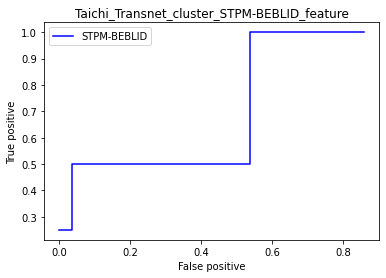

In [14]:
from matplotlib import pyplot as plt
import numpy as np
import math #needed for definition of pi
x = np.arange(0, len(res), 1)
y1 = map_fet
y2 = mar_fet
#y3 = map_fet_fft
#y4 = mar_fet_fft
plt.plot(y2,y1, "-b", label="STPM-BEBLID")
#plt.plot(y4,y3, "-g", label = "STPM-BEBLID")
plt.xlabel("False positive")
plt.ylabel("True positive")
plt.title('Taichi_Transnet_cluster_STPM-BEBLID_feature')
plt.legend()
plt.show()

In [15]:
#CBVR SAMPLE TEST BENCH FOR STPM_SIFT_HISTOGRAM_INTERSECTION / STPM_BEBLID_HISTOGRAM_INTERSECTION BASED COMPARISONS
#Accessing the feature database

#OPENCV VERSION FOR ORB AND BEBLID
#!pip install "opencv-contrib-python>=4.5.1"

import pickle
import cv2
import numpy as np
import pandas as pd
from pandas import DataFrame
import math
from sklearn.cluster import KMeans
from sklearn import preprocessing

#40800
def histogram_intersection(h1, h2, l):
    sm = 0

    for i in range(l):
        sm += min(h1[i], h2[i])
    return sm


# List to store result
feature_result = []

#CODE TO EXTRACT FEATURES FROM QUERY IMAGE


#QUERY VIDEO
import cv2
import numpy as np

import math

def extract_denseSIFT(img):
    DSIFT_STEP_SIZE = 2
    #sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.xfeatures2d.BEBLID_create(1)
    disft_step_size = DSIFT_STEP_SIZE
    keypoints = [cv2.KeyPoint(x, y, disft_step_size)
            for y in range(0, img.shape[0], disft_step_size)
                for x in range(0, img.shape[1], disft_step_size)]

    descriptors = sift.compute(img, keypoints)[1]
    
    #keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

L = 1
#QUERY VIDEO
filepath = '/content/KTH-Action-Recognition/dataset/TaiChi/v_TaiChi_g01_c01.avi'
vid = cv2.VideoCapture(filepath)

            # Store features in current file.
features_current_file_new = []
count_frame = 0
while vid.isOpened():
  ret, frame = vid.read()
  count_frame = count_frame + 1
  if not ret:
    break
  if(count_frame < (2**L + 1)):
  # Only care about gray scale.
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    W = frame.shape[1]
    H = frame.shape[0]   
    h = []
    for l in range(L+1):
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):
            x = 0
            for j in range(1, 2**l + 1):                
                desc = extract_denseSIFT(frame[y:y+h_step, x:x+w_step])                
                #print("type:",desc is None, "x:",x,"y:",y, "desc_size:",desc is None)
                kmeans = KMeans(n_clusters=60, init='k-means++', max_iter=300, n_init=10, random_state=0)
                predict = kmeans.fit_predict(desc)
                histo = np.bincount(predict, minlength=60).reshape(1,-1).ravel()
                weight = 2**(l-L)
                h.append(weight*histo)
                x = x + w_step
            y = y + h_step
            
    hist = np.array(h).ravel()
    # normalize hist
    dev = np.std(hist)
    hist -= np.mean(hist)
    hist /= dev

    features_current_file_new.append(hist)
    
    features_current_file = np.array(features_current_file_new)
# No of frames
print(len(features_current_file))  
            

            





# open a file, where you stored the pickled data
file = open('/content/KTH-Action-Recognition/dataset/data/BEBLID_stpm_UCF50_L1.p', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:')


cnt = 0
for item in data:
    #print('The data ', cnt, ' is : ', item['path'])
    print('The data ', cnt, ' is : ', len(item['features']))

    
    point_a = np.array(item['features'])
    point_a = point_a.ravel()

    point_b = np.array(features_current_file)
    point_b = point_b.ravel()

    #distance = np.linalg.norm(point_a - point_b)
    distance = histogram_intersection(point_a, point_b, len(point_a))
    print(distance)
    
    feature_result.append({
                
                "path" : item['path'],
                "similarity" : distance,
                "category" : item['category'] 
            })

    cnt += 1

print(feature_result)
df = DataFrame (feature_result)
print (df)



df1 = df[df['similarity'] < 0].sort_values(by=['similarity'], ascending=False)
print(df1)


2
Showing the pickled data:
The data  0  is :  2
-125.24283773232682
The data  1  is :  2
-105.64995440956933
The data  2  is :  2
-86.6165139672446
The data  3  is :  2
-92.2178327198676
The data  4  is :  2
-73.70294398071695
The data  5  is :  2
-77.6511377151095
The data  6  is :  2
-219.6174821105266
The data  7  is :  2
-215.88514799847127
The data  8  is :  2
-116.90699951834667
The data  9  is :  2
-221.85505705546146
The data  10  is :  2
-97.42788864055922
The data  11  is :  2
-196.1789784765763
The data  12  is :  2
-81.43100365762082
The data  13  is :  2
-103.14386101847484
The data  14  is :  2
-75.0442204133665
The data  15  is :  2
-73.3988346491148
The data  16  is :  2
-84.51788481721856
The data  17  is :  2
-109.45753159716551
The data  18  is :  2
-99.58505801525789
The data  19  is :  2
-88.22807455977292
The data  20  is :  2
-95.66919051201856
The data  21  is :  2
-86.28037998285724
The data  22  is :  2
-74.4934963261179
The data  23  is :  2
-134.93595333444

In [16]:
#MEAN AVERAGE PRECISION
import matplotlib.pyplot as plt

TP = 0
FP = 0

Total = len(df1) 
print(Total)
res = []
query = 'TaiChi'
#for i in range(0,Total):
for index, row in df1.iterrows():
  #print(row['category'])
  res.append(row['category'])
print(res)
print(len(res))

map = []
for i in range(0,len(res)):
  if(res[i] == query):
    map.append(1)
  else:
    map.append(0)

print(map)  

map_fet_fft = []
mar_fet_fft = []
mTP = 0

mTR = 0
for i in range(0,len(map)):
  if map[i] == 1:
    TP = TP + 1
    
  #true positive rate
    mTP = TP / (4)
  map_fet_fft.append(mTP)  
  if map[i] == 0:
    FP = FP + 1
    #false positive rate
    mTR = FP / (28)
  mar_fet_fft.append(mTR)
    
  
print(map_fet_fft)
print(mar_fet_fft)



28
['TaiChi', 'PlayingGuitar', 'JumpingJack', 'Skijet', 'PlayingGuitar', 'JumpingJack', 'TaiChi', 'PlayingGuitar', 'Rowing', 'Skijet', 'Biking', 'Rowing', 'Biking', 'Skijet', 'Kayaking', 'Rowing', 'PlayingGuitar', 'Biking', 'Rowing', 'Kayaking', 'TaiChi', 'TaiChi', 'Biking', 'Skijet', 'Kayaking', 'JumpingJack', 'JumpingJack', 'Kayaking']
28
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 0.03571428571428571, 0.07142857142857142, 0.10714285714285714, 0.14285714285714285, 0.17857142857142858, 0.17857142857142858, 0.21428571428571427, 0.25, 0.2857142857142857, 0.32142857142857145, 0.35714285714285715, 0.39285714285714285, 0.42857142857142855, 0.4642857142857143, 0.5, 0.5357142857142857, 0.5714285714285714, 0.6071428571428571, 0.6428571428571429, 0.6428571428571429, 0.6428571428571429, 0.6785714285714286

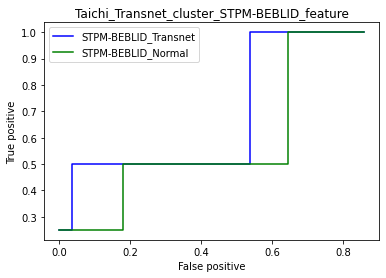

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import math #needed for definition of pi
x = np.arange(0, len(res), 1)
y1 = map_fet
y2 = mar_fet
y3 = map_fet_fft
y4 = mar_fet_fft
plt.plot(y2,y1, "-b", label="STPM-BEBLID_Transnet")
plt.plot(y4,y3, "-g", label = "STPM-BEBLID_Normal")
plt.xlabel("False positive")
plt.ylabel("True positive")
plt.title('Taichi_Transnet_cluster_STPM-BEBLID_feature')
plt.legend()
plt.show()

In [ ]:
#from sympy import fwht

import pickle
import pandas as pd
from scipy.fft import fft, fftfreq
import numpy as np


df1 = pd.read_pickle('/content/seqkeyframes_BEBLID_stpm_UCF50_L1.p')
#df = df.filter(['path', 'features'])
print(df1[23]['path'])
print(len(df1))





feat = []
for i in range(len(df1)):

  a = np.array(df1[i]['features'])
  print(a)
  
  b = fft(a)
  b = np.abs(b)
  
  feat.append({
                "filename": df1[i]['filename'],
                "path" : df1[i]['path'],
                "category": df1[i]['category'],
                "feature1": b
                
            })

print(feat)
pickle.dump(feat, open("Seqkeyframe_BEBLID_FFT.p" , "wb"))



Streaming output truncated to the last 5000 lines.
   1.71034367e-02 -1.96689522e-01 -2.87907851e-01 -3.30666443e-01
   3.70574461e-02  7.98160379e-02 -1.51080357e-01 -3.27815870e-01
  -3.70574461e-01  7.86187973e+00  3.87677898e-01 -4.33287063e-01
  -4.78896227e-01 -2.62252696e-01 -2.28045822e-01 -7.98160379e-02
  -4.50390499e-01  5.87217993e-01  1.99540095e-01  4.67493936e-01
   1.71034367e-02  8.15263815e-01 -2.50850405e-01 -1.59632076e-01
  -2.05241240e-01 -2.50850405e-01 -4.10482480e-01 -3.30666443e-01
  -4.73195082e-01 -1.76735512e-01 -1.08321766e-01 -7.41148923e-02
  -2.96459569e-01 -1.31126348e-01 -4.73195082e-01 -3.93379044e-01
  -3.93379044e-01 -1.82436658e-01 -2.16643531e-01 -3.87677898e-01
  -3.07861860e-01 -1.31126348e-01 -1.88137804e-01 -2.62252696e-01
  -4.16183626e-01 -2.05241240e-01 -1.76735512e-01 -3.87677898e-01
  -2.62252696e-01 -3.87677898e-01 -4.04781335e-01 -2.28045822e-01
  -3.70574461e-01 -2.96459569e-01 -2.05241240e-01 -4.61792790e-01
  -3.42068734e-01 -4.9029

In [ ]:
#Fast Fourier Transform
#CBVR SAMPLE TEST BENCH FOR STPM_SIFT_HISTOGRAM_INTERSECTION / STPM_BEBLID_HISTOGRAM_INTERSECTION BASED COMPARISONS
#Accessing the feature database
import pickle
import cv2
import numpy as np
import pandas as pd
from pandas import DataFrame
import math
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.fft import fft, fftfreq
import numpy as np
#from similaritymeasures import Similarity


#40800
def histogram_intersection(h1, h2, l):
    sm = 0

    for i in range(l):
        sm += min(h1[i], h2[i])
    return sm


# List to store result
feature_result = []

#CODE TO EXTRACT FEATURES FROM QUERY IMAGE


#QUERY VIDEO
import cv2
import numpy as np

import math

def extract_denseSIFT(img):
    DSIFT_STEP_SIZE = 2
    #sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.xfeatures2d.BEBLID_create(1)
    disft_step_size = DSIFT_STEP_SIZE
    keypoints = [cv2.KeyPoint(x, y, disft_step_size)
            for y in range(0, img.shape[0], disft_step_size)
                for x in range(0, img.shape[1], disft_step_size)]

    descriptors = sift.compute(img, keypoints)[1]
    
    #keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

L = 1
#QUERY VIDEO
filepath = '/content/Kayaking1.mp4'
vid = cv2.VideoCapture(filepath)

            # Store features in current file.
features_current_file_new = []
count_frame = 0
while vid.isOpened():
  ret, frame = vid.read()
  count_frame = count_frame + 1
  if not ret:
    break
  if(count_frame < (2**L + 1)):
  # Only care about gray scale.
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    W = frame.shape[1]
    H = frame.shape[0]   
    h = []
    for l in range(L+1):
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):
            x = 0
            for j in range(1, 2**l + 1):                
                desc = extract_denseSIFT(frame[y:y+h_step, x:x+w_step])                
                #print("type:",desc is None, "x:",x,"y:",y, "desc_size:",desc is None)
                kmeans = KMeans(n_clusters=60, init='k-means++', max_iter=300, n_init=10, random_state=0)
                predict = kmeans.fit_predict(desc)
                histo = np.bincount(predict, minlength=60).reshape(1,-1).ravel()
                weight = 2**(l-L)
                h.append(weight*histo)
                x = x + w_step
            y = y + h_step
            
    hist = np.array(h).ravel()
    # normalize hist
    dev = np.std(hist)
    hist -= np.mean(hist)
    hist /= dev

    features_current_file_new.append(hist)
    
    features_current_file = np.array(features_current_file_new)

    

# No of frames
print(len(features_current_file))  
features_current_file = np.abs(fft(features_current_file))            

            





# open a file, where you stored the pickled data
file = open('/content/Seqkeyframe_BEBLID_FFT.p', 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:')


cnt = 0
for item in data:
    #print('The data ', cnt, ' is : ', item['path'])
    print('The data ', cnt, ' is : ', len(item['feature1']))

    
    point_a = np.array(item['feature1'])
    point_a = point_a.ravel()

    point_b = np.array(features_current_file)
    point_b = point_b.ravel()

    distance = np.linalg.norm(point_a - point_b)
    #distance = histogram_intersection(point_a, point_b, len(point_a))
    print(distance)
    
    feature_result.append({
                
                "path" : item['path'],
                "similarity" : distance,
                "category" : item['category'] 
            })

    cnt += 1

print(feature_result)
df = DataFrame (feature_result)
print (df)



#df1 = df[df['similarity'] > 0].sort_values(by=['similarity']), ascending=False)
df1 = df.sort_values("similarity")
print(df1)


2
Showing the pickled data:
The data  0  is :  2
255.00297905196808
The data  1  is :  2
279.84951820996054
The data  2  is :  2
266.77249558761275
The data  3  is :  2
278.82204385086885
The data  4  is :  2
256.513221318996
The data  5  is :  2
253.09944044565762
The data  6  is :  2
288.98044226650234
The data  7  is :  2
332.1292408051452
The data  8  is :  2
0.0
The data  9  is :  2
308.54183815545576
The data  10  is :  2
251.30013248628342
The data  11  is :  2
262.3753034189558
The data  12  is :  2
293.04454017084146
The data  13  is :  2
279.56790647629646
The data  14  is :  2
294.7450293071127
The data  15  is :  2
261.27581691907665
The data  16  is :  2
278.15566672597754
The data  17  is :  2
264.21735277753555
The data  18  is :  2
265.94258893133184
The data  19  is :  2
259.77716037369055
The data  20  is :  2
272.8864349184791
The data  21  is :  2
265.7709532391649
The data  22  is :  2
255.47400464015382
The data  23  is :  2
284.72034318316173
The data  24  is :  